In [1]:
import torch
import pandas as pd
import numpy as np
import os
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns
import time 

In [2]:
compiled_datasets = pd.read_csv('./data/dataset_files/compiled_datasets_sessions.csv')
dnn_df = pd.read_csv('./data/dataset_files/DNN.csv')
gmm_df = pd.read_csv('./data/dataset_files/GMM.csv')
clinical_df = pd.read_csv('./data/dataset_files/ground_truth_and_clinical_ratings_compiled.csv')

/home/prad/anaconda3/envs/alignment/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (0,453,455,456,471,476,477,479,494,495,496,498,499,500,501,502,503,504,505,506,507) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [99]:
dnn_df[dnn_df['sample'].str.contains('crowd')]

,File_id,N,M,ng,g,b,d,k,t,p,...,uh,uw,er,sil,Nasals,Stops,Fricatives,Semivowels,Vowels,sample
0,0a571e6d-633c-4869-bba1-d91bd6e95404,-0.003500,0.000000,-0.512395,0.000000,0.000000,-0.005883,-0.002108,-0.125223,0.000000,...,NaN,-0.256701,-0.084762,-1.721460,-0.171965,-0.022202,-0.120757,-0.021320,-0.067187,crowd
1,0c1fdf06-f616-4507-9c78-1c89fe60e81e,-0.007689,0.000000,-0.480122,0.000000,0.000000,-0.104180,0.000000,-0.064464,0.000000,...,NaN,-0.119657,0.000000,-0.462315,-0.162604,-0.028107,-0.034396,-0.000746,-0.060833,crowd
2,0c4dfa73-c157-4f29-ba38-c7d04f21e5cf,0.000000,0.000000,-0.592336,0.000000,0.000000,-0.069439,0.000000,-0.134363,-0.061658,...,-1.8983,-0.147563,-0.103293,-0.797658,-0.197445,-0.044243,-0.058736,-0.004633,-0.172262,crowd
3,0d28f4dc-c3d1-4b35-9f5d-edcdf369627f,-0.133370,-0.199263,-1.499860,0.000000,-0.454666,-0.358189,-0.215730,-0.305925,-0.656270,...,NaN,-0.657046,-0.243949,-1.740780,-0.610831,-0.331797,-0.331823,-0.105069,-0.309353,crowd
4,0d34db8b-e8fd-4096-bf87-7d1dd26cddde,-0.193277,-0.207042,-1.447310,0.000000,-0.600477,-0.568570,-0.366319,-0.358764,-0.666745,...,NaN,-0.543960,-0.175808,-1.883530,-0.615876,-0.426812,-0.348067,-0.158258,-0.400409,crowd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,ef217cff-a4f5-4892-a253-34811d98f3cb,-0.016019,-0.009984,-0.681377,0.000000,0.000000,-0.090206,-0.070997,-0.103948,-0.126633,...,NaN,-0.171071,-0.009236,-0.473205,-0.235793,-0.065297,-0.080673,-0.039173,-0.076201,crowd_issue
227,ef449360-8cdd-4e2c-bac5-d35fa8a0f5a2,-0.026356,0.000000,-1.337010,0.000000,0.000000,-0.027549,0.000000,-0.082393,-0.020911,...,NaN,-0.272849,-0.107775,-0.832979,-0.454455,-0.021809,-0.210814,-0.107036,-0.058994,crowd_issue
228,f5d8589b-5127-4f84-8401-973c00fd746e,-0.076483,0.000000,-2.008240,-0.223133,0.000000,-0.154143,0.000000,-0.094314,-0.204570,...,NaN,-0.213523,-0.134686,-0.460322,-0.694908,-0.112693,-0.112684,-0.072409,-0.102417,crowd_issue
229,f9f0c5b1-52af-4bb3-97de-1d53ea93d4a7,-0.023437,0.000000,-1.064250,0.000000,0.000000,-0.107267,0.000000,-0.059820,-0.114914,...,NaN,-0.125273,0.000000,-0.790501,-0.362562,-0.047000,-0.047988,-0.018267,-0.044185,crowd_issue


In [3]:
''' Compute mean artp for each session'''
STEP_TO_TRANSCRIPT = {
'3': 'Much more money must be donated to make this department succeed',
'4': 'In this famous coffee shop they serve the best donuts in town',
'5': 'The chairman decided to pave over the shopping center garden', 
'6': 'The standards committee met this afternoon in an open meeting'}
steps = list(STEP_TO_TRANSCRIPT.keys())


In [4]:
dignity_files = compiled_datasets[~pd.isna(compiled_datasets['Participant'])]
dignity_files = pd.isna(compiled_datasets['Participant'].str.contains('DIGNI'))

crowdfiles = compiled_datasets[~pd.isna(compiled_datasets['Participant'])]
crowdfiles = pd.isna(compiled_datasets['Participant'].str.contains('DIGNI'))

In [5]:
alsathome_dir = '/home/prad/datasets/als_at_home'
alsathome_dfpath = os.path.join(alsathome_dir, 'als_at_home_primary_covariates_existing_files_only.csv')
als_datadir = os.path.join(alsathome_dir, 'als_at_home_audio_files')
alsathome_df = pd.read_csv(alsathome_dfpath)

In [6]:
from gop_helper_fns import *

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/prad/anaconda3/envs/alignment/lib/python3.7/site-packages/transformers/configuration_utils.py:359: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "


In [7]:
phones = ['N', 'M', 'ng', 'g', 'b', 'd', 'k', 't', 'p', 's', 'sh', 'dh', 'th', 'z', 'jh', 'ch', 'f', 'v', 'r', 'l', 'aa', 'ah', 'ae', 'ao', 'aw', 'ay', 'eh', 'ey', 'iy', 'ih', 'ow', 'oy', 'uh', 'uw', 'er']

dnn_df = pd.read_csv('./data/dataset_files/DNN.csv')
gmm_df = pd.read_csv('./data/dataset_files/GMM.csv')

dnnals_df = dnn_df[dnn_df['sample'].str.contains('ALS') | dnn_df['sample'].str.contains('crowd')]
dnnals_df['vikram_artp'] = dnnals_df[phones].mean(axis=1)

gmmals_df = gmm_df[gmm_df['sample'].str.contains('ALS') | gmm_df['sample'].str.contains('crowd')]
gmmals_df['artp'] = gmmals_df[phones].mean(axis=1)

w2v_df = dnn_df[dnn_df['sample'].str.contains('ALS') | dnn_df['sample'].str.contains('crowd')]

gmmals_df = gmmals_df.sort_values('File_id')
dnnals_df = dnnals_df.sort_values('File_id')
w2v_df = w2v_df.sort_values('File_id')

gmmals_df = gmmals_df.set_index('File_id')
dnnals_df = dnnals_df.set_index('File_id')
w2v_df = w2v_df.set_index('File_id')

In [8]:
''' run all session ids in validation df'''
validation_results_dict = '/home/prad/github/charsiu/alsathome_validation_artps_fixed.pkl'
if not os.path.exists(validation_results_dict):
    session_artp_validation_dict = {}
    for sessid in tqdm.tqdm(w2v_df.index):
        session_artp_validation_dict[sessid] = {}
        for step in steps:
            step_filepath = os.path.join(als_datadir, sessid) + '-%s.wav' % step
            TRANSCRIPT = STEP_TO_TRANSCRIPT[step]
            try:
                step_artp = calculate_GOP_e2e(audio_filepath=step_filepath, transcript=TRANSCRIPT)
                session_artp_validation_dict[sessid][step] = step_artp
                time.sleep(.01)
            except:
                session_artp_validation_dict[sessid][step] = np.nan
                print('Exception for:\t', step_filepath)
    pkl.dump(session_artp_validation_dict, open(validation_results_dict, 'wb'))    
else:
    session_artp_validation_dict = pkl.load(open(validation_results_dict, 'rb'))
    
w2v_df['w2v_artp'] = np.zeros(len(w2v_df))
for ii, sessid in enumerate(w2v_df.index):
    if 'ALS' in w2v_df.loc[sessid, 'sample']:
        _sessartp = np.nanmean(list(session_artp_validation_dict[sessid].values()))
        w2v_df.loc[sessid, 'w2v_artp'] = _sessartp

/home/prad/anaconda3/envs/alignment/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice


In [9]:
''' load the crowdsource run'''

sess_artp_validation_dict_crowd = pkl.load(open('crowd_validation_artps_fixed.pkl.upload', 'rb'))
for ii, sessid in enumerate(w2v_df.index):
    if 'crowd' in w2v_df.loc[sessid, 'sample']:
        _sessartp = np.nanmean(list(sess_artp_validation_dict_crowd[sessid].values()))
        w2v_df.loc[sessid, 'w2v_artp'] = _sessartp

/home/prad/anaconda3/envs/alignment/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


In [ ]:
joined_df = gmmals_df.merge(dnnals_df, how='inner', on='File_id')
joined_df = joined_df.merge(w2v_df, how='inner', on='File_id')

In [64]:
''' subset artp by frs score '''
artp_methods = ['artp', 'vikram_artp', 'w2v_artp']
artp_method_name_dict = {'artp': 'ArtP', 'vikram_artp': 'DNN GOP', 'w2v_artp': 'W2V ArtP'}
frs_artp_dict = {}
frs_vals = np.arange(0, 5, step=1)

for artp_key in artp_methods:
    print('****************** Method: %s ***************' % artp_key)
    # sum(alsathome_df['speech']==4)
    frs_artps = []
    for frsval in frs_vals:
        frs_artp = []
        frs_sessids = alsathome_df[alsathome_df['speech']==frsval]['session']
        print('For frs=%d' % frsval)
        notfound_sessions = 0

        for sessid in frs_sessids:
            try:
                _artp = joined_df.loc[sessid, artp_key]
                frs_artp.append(_artp)
            except:
                notfound_sessions +=1
                # print('sessid not found:\t', sessid)
        frs_artps.append(frs_artp)
        print(notfound_sessions, ' sessions not found')
    # print(len(frs_artps))
    frs_artp_dict[artp_key] = frs_artps

****************** Method: artp ***************
For frs=0
0  sessions not found
For frs=1
9  sessions not found
For frs=2
0  sessions not found
For frs=3
0  sessions not found
For frs=4
0  sessions not found
5
****************** Method: vikram_artp ***************
For frs=0
0  sessions not found
For frs=1
9  sessions not found
For frs=2
0  sessions not found
For frs=3
0  sessions not found
For frs=4
0  sessions not found
5
****************** Method: w2v_artp ***************
For frs=0
0  sessions not found
For frs=1
9  sessions not found
For frs=2
0  sessions not found
For frs=3
0  sessions not found
For frs=4
0  sessions not found
5


In [59]:
frs_artp_data

[[], [], [], [], []]

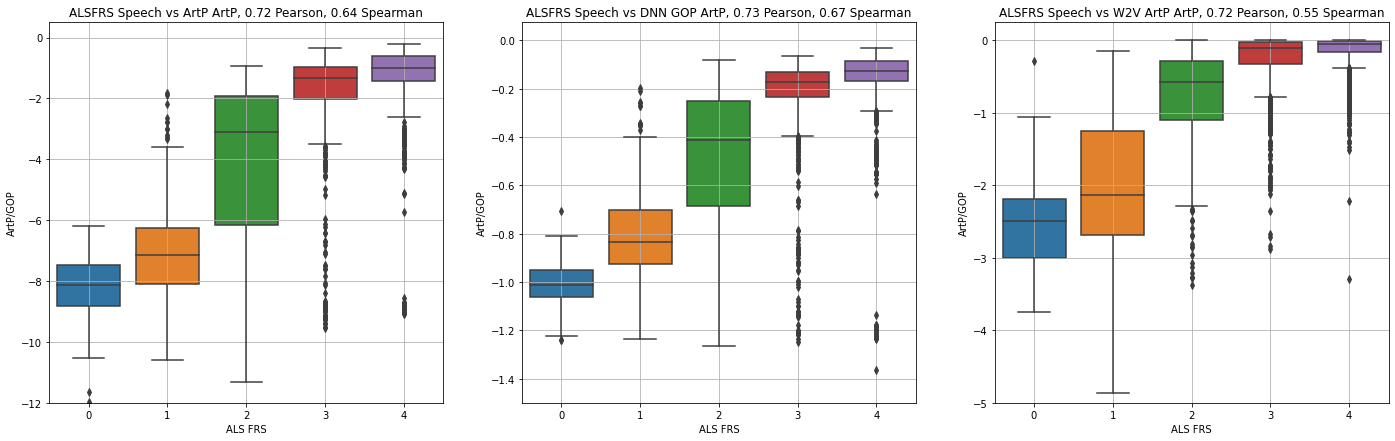

In [94]:
plt.figure(figsize = (24, 7))

for ii, artp_method in enumerate(artp_methods):
    frs_artp_data = frs_artp_dict[artp_method]
    # print(frs_artp_data)
    plt.subplot(1, 3, ii+1)
    ax = sns.boxplot(data=frs_artp_data)
    ax.set(xticklabels=['0', '1', '2', '3', '4'])
    if artp_method=='artp':
        plt.ylim([-12, .5])
    elif artp_method=='vikram_artp':
        plt.ylim([-1.5, .075])        
    elif artp_method=='w2v_artp':
        plt.ylim([-5, .25])
    
    _frsvector = np.concatenate([_frs * np.ones(len(_artps)) for (_frs, _artps) in zip(frs_vals, frs_artp_data)])
    _artpvector = np.concatenate(frs_artp_data)
    nonanids = np.argwhere(~np.isnan(_artpvector)).ravel()
    pearson = np.corrcoef(_frsvector[nonanids], _artpvector[nonanids])[0,1]
    from scipy.stats import spearmanr
    spearman = spearmanr(_frsvector[nonanids], _artpvector[nonanids]).correlation
    plt.title('ALSFRS Speech vs %s ArtP, %.2f Pearson, %.2f Spearman' % (artp_method_name_dict[artp_method], pearson, spearman))
    plt.ylabel('ArtP/GOP')
    plt.xlabel('ALS FRS')
    plt.grid(True)

In [ ]:
sum(np.logical_and(joined_df.index.str[0] == '2', joined_df['sample'].str.contains('ALS')))

1639

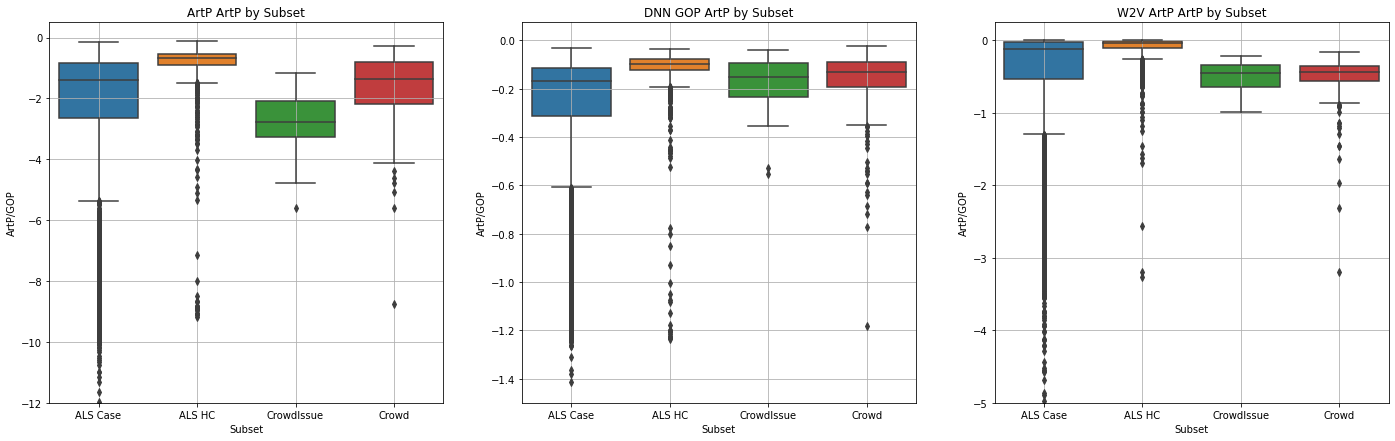

In [87]:
plt.figure(figsize = (24, 7))

for ii, artp_method in enumerate(artp_methods):
    plt.subplot(1, 3, ii+1)
    if artp_method=='artp':
        plt.ylim([-12, .5])
    elif artp_method=='vikram_artp':
        plt.ylim([-1.5, .075])        
    elif artp_method=='w2v_artp':
        plt.ylim([-5, .25])
    crowdissue = joined_df.loc[joined_df['sample'].str.contains('crowd_issue'), artp_method]
    crowdnormal = joined_df.loc[joined_df['sample'].str.contains('crowd'), artp_method]
    als_hc_inds = np.logical_and(joined_df.index.str[0] == '2', joined_df['sample'].str.contains('ALS'))
    als_case_inds = np.logical_and(joined_df.index.str[0] == '1', joined_df['sample'].str.contains('ALS'))
    als_hc = joined_df.loc[als_hc_inds, artp_method]
    als_case = joined_df.loc[als_case_inds, artp_method]
    artp_boxplot_data = [als_case, als_hc, crowdissue, crowdnormal]
    
    ax = sns.boxplot(data=artp_boxplot_data)
    ax.set(xticklabels=['ALS Case', 'ALS HC', 'CrowdIssue', 'Crowd'])
    plt.grid(True)
    plt.title('%s ArtP by Subset' % (artp_method_name_dict[artp_method]))
    plt.ylabel('ArtP/GOP')
    plt.xlabel('Subset')

In [ ]:
crowd_noisy = joined_df[joined_df['sample'].str.contains('crowd_issue')]
crowd_noisy['dnn_gop'] = crowd_noisy['vikram_artp']
pltdf = crowd_noisy[['artp', 'dnn_gop', 'w2v_artp']]
import seaborn as sns
sns.boxplot(x="variable", y="value", data=pd.melt(pltdf))
plt.title('ArtP Measures for CrowdSource Noisy Files')
plt.xlabel('ArtP Measure')
plt.ylabel('ArtP Value')

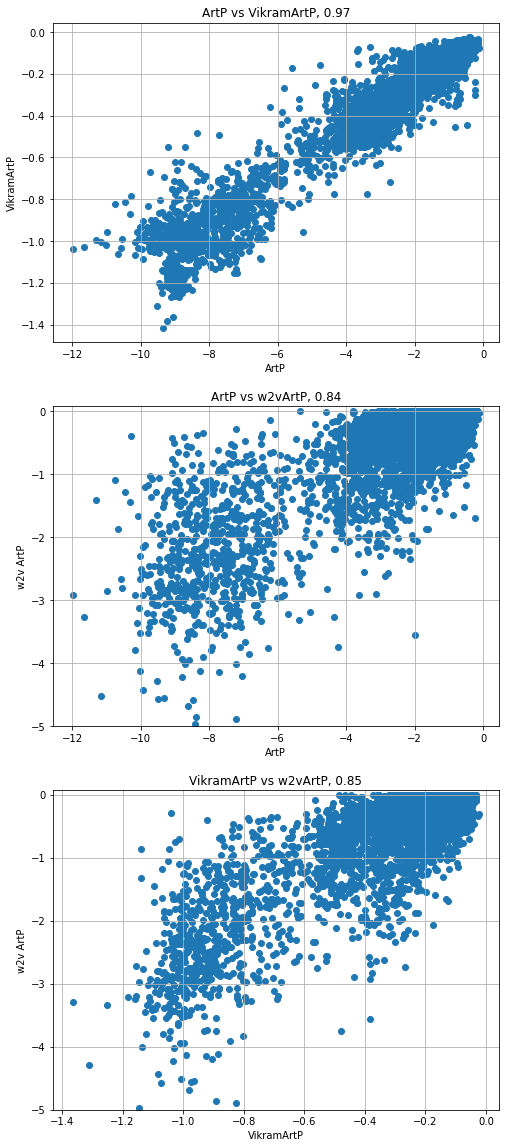

In [96]:
plt.figure(figsize=(8,20))
plt.subplot(3,1,1)
plt.title('ArtP vs VikramArtP, %.2f' % joined_df['artp'].corr(joined_df['vikram_artp']))
plt.scatter(joined_df['artp'], joined_df['vikram_artp'])
plt.xlabel('ArtP')
plt.ylabel('VikramArtP')
plt.grid()

plt.subplot(3,1,2)
plt.title('ArtP vs w2vArtP, %.2f' % joined_df['artp'].corr(joined_df['w2v_artp']))
plt.ylim([-5, .075])
plt.scatter(joined_df['artp'], joined_df['w2v_artp'])
plt.xlabel('ArtP')
plt.ylabel('w2v ArtP')
plt.grid()


plt.subplot(3,1,3)
plt.title('VikramArtP vs w2vArtP, %.2f' % joined_df['vikram_artp'].corr(joined_df['w2v_artp']))
plt.scatter(joined_df['vikram_artp'], joined_df['w2v_artp'])
plt.ylim([-5, .075])
plt.xlabel('VikramArtP')
plt.ylabel('w2v ArtP')
plt.grid()

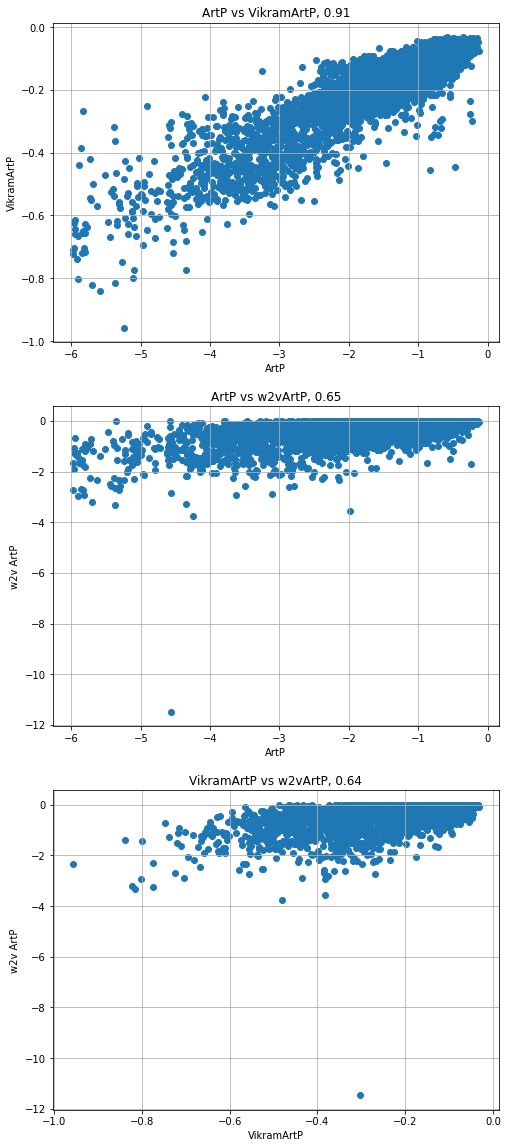

In [14]:
inds = joined_df['artp']>-6
gt6df = joined_df[joined_df['artp']>-6]
plt.figure(figsize=(8,20))
plt.subplot(3,1,1)
plt.title('ArtP vs VikramArtP, %.2f' % gt6df['artp'].corr(gt6df['vikram_artp']))
plt.scatter(gt6df['artp'], gt6df['vikram_artp'])
plt.xlabel('ArtP')
plt.ylabel('VikramArtP')
plt.grid()

plt.subplot(3,1,2)
plt.title('ArtP vs w2vArtP, %.2f' % gt6df['artp'].corr(gt6df['w2v_artp']))
plt.scatter(gt6df['artp'], gt6df['w2v_artp'])
plt.xlabel('ArtP')
plt.ylabel('w2v ArtP')
plt.grid()


plt.subplot(3,1,3)
plt.title('VikramArtP vs w2vArtP, %.2f' % gt6df['vikram_artp'].corr(gt6df['w2v_artp']))
plt.scatter(gt6df['vikram_artp'], gt6df['w2v_artp'])
plt.xlabel('VikramArtP')
plt.ylabel('w2v ArtP')
plt.grid()

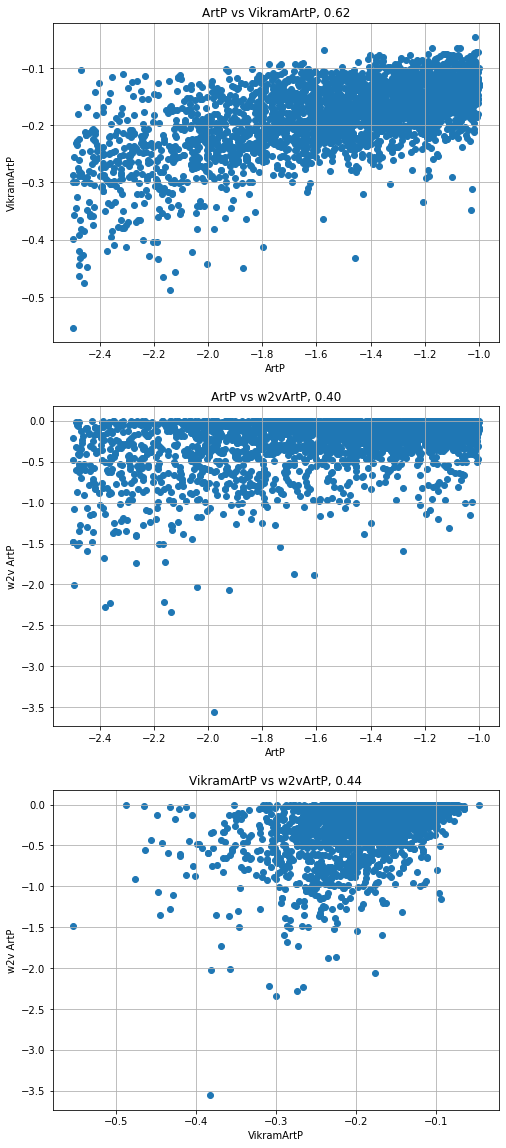

In [15]:
inds = joined_df['artp']>-6
gt25lt1df = joined_df[joined_df['artp'].between(-2.5, -1)]
plt.figure(figsize=(8,20))
plt.subplot(3,1,1)
plt.title('ArtP vs VikramArtP, %.2f' % gt25lt1df['artp'].corr(gt25lt1df['vikram_artp']))
plt.scatter(gt25lt1df['artp'], gt25lt1df['vikram_artp'])
plt.xlabel('ArtP')
plt.ylabel('VikramArtP')
plt.grid()

plt.subplot(3,1,2)
plt.title('ArtP vs w2vArtP, %.2f' % gt25lt1df['artp'].corr(gt25lt1df['w2v_artp']))
plt.scatter(gt25lt1df['artp'], gt25lt1df['w2v_artp'])
plt.xlabel('ArtP')
plt.ylabel('w2v ArtP')
plt.grid()


plt.subplot(3,1,3)
plt.title('VikramArtP vs w2vArtP, %.2f' % gt25lt1df['vikram_artp'].corr(gt25lt1df['w2v_artp']))
plt.scatter(gt25lt1df['vikram_artp'], gt25lt1df['w2v_artp'])
plt.xlabel('VikramArtP')
plt.ylabel('w2v ArtP')
plt.grid()

In [17]:
highw2vapdf = gt25lt1df[gt25lt1df['w2v_artp']>-.1]
highw2vapdf_lowerartp=highw2vapdf[highw2vapdf['artp']<-2.2]
highw2vapdf_higherartp=highw2vapdf[highw2vapdf['artp']>-1.6]
artp_cols = ['vikram_artp', 'w2v_artp', 'artp']

In [18]:
print('Understanding w2v ArtP saturation problem')
print('Files with lower Artp, but high w2v artp')
highw2vapdf_lowerartp[artp_cols]

#1078-20180630-0934	 - very quiet, but good articulation
#2011-20180130-1121	 - sounds normal, not sure why artp and vikram_artp are lower

# supervised learning of other artp score

Understanding w2v ArtP saturation problem
Files with lower Artp, but high w2v artp


,vikram_artp,w2v_artp,artp
File_id,,,
1008-20170812-1528,-0.262210,-0.040289,-2.341065
1008-20180108-1714,-0.290857,-0.045827,-2.294031
1008-20180124-1025,-0.224484,-0.013801,-2.477504
1011-20170524-0914,-0.312720,-0.060375,-2.324053
1042-20171102-1037,-0.122836,-0.003199,-2.261787
1042-20171103-1030,-0.110151,-0.002225,-2.315243
1042-20180104-1759,-0.125051,-0.016475,-2.280872
1042-20180106-1928,-0.126311,-0.092603,-2.405024
1042-20180131-1257,-0.141140,-0.091667,-2.417631


In [19]:
highw2vapdf_higherartp[artp_cols]

,vikram_artp,w2v_artp,artp
File_id,,,
1003-20170523-2006,-0.144306,-0.008691,-1.258865
1003-20170531-0951,-0.150520,-0.028614,-1.220010
1003-20170608-1519,-0.162831,0.000000,-1.317706
1003-20170617-1442,-0.147374,-0.081035,-1.373232
1003-20170711-1618,-0.158596,-0.072214,-1.232898
...,...,...,...
2028-20180625-2342,-0.144922,-0.099763,-1.327612
2028-20180724-2126,-0.150214,-0.025552,-1.254540
2028-20181018-1159,-0.150997,-0.033197,-1.047235


In [20]:
lowartp_df = joined_df[joined_df['artp']<-6]

In [21]:
print('Columns where Artp is very low (<-6) and w2v2 artp is at least moderate (>-.5)')
lowartp_df[lowartp_df['w2v_artp']>-.5][artp_cols].sort_values('w2v_artp', ascending=False)

# 1066-20180521-2143 - w2v artp high because vowels get extended, extreme impairment
# 1066-20180405-2034 - same as above
# 1073-20180601-0917 - laughing in file, significant impairment
# 1081-20180602-1918 - w2v artp higher from extended vowels, extreme impairment

Columns where Artp is very low (<-6) and w2v2 artp is at least moderate (>-.5)


,vikram_artp,w2v_artp,artp
File_id,,,
1073-20180601-0917,-0.361131,-0.136059,-6.217813
1036-20170928-1101,-1.038820,-0.287002,-7.231621
1078-20180715-0847,-0.708464,-0.355683,-8.193112
1077-20180505-0537,-0.689411,-0.356781,-6.075805
1077-20180501-0614,-0.787428,-0.371750,-6.473902
1109-20180814-0637,-0.713520,-0.382598,-8.361543
1109-20180918-0803,-0.783718,-0.401456,-10.278194
1078-20180603-1445,-0.921203,-0.405705,-8.733270
1077-20180520-0648,-0.737078,-0.406956,-6.501109


In [22]:
lowartp_df[artp_cols]
print(lowartp_df.shape[0], 'files with very low artp, medium w2v artp')
print(sum(lowartp_df.index.str[0]=='2'), 'healthy')

853 files with very low artp, medium w2v artp
20 healthy


In [23]:
def compute_session_artp(session_id, steps=steps):
    step_artps = []
    for step in steps:
        step_filepath = os.path.join(als_datadir, sessid) + '-%s.wav' % step
        TRANSCRIPT = STEP_TO_TRANSCRIPT[step]
        try:
            step_artp = calculate_GOP_e2e(audio_filepath=step_filepath, transcript=TRANSCRIPT)
            step_artps.append(step_artp)
            time.sleep(.01)
        except:
            return np.nan
    return np.mean(step_artps)



In [45]:
compute_session_artp(lowartp_df.index[0])

-0.13986646

In [24]:
_sessid = lowartp_df.index[0]
print(_sessid)
_step = '3'
audio_filepath = os.path.join(als_datadir, _sessid) + '-%s.wav' % _step
TRANSCRIPT = STEP_TO_TRANSCRIPT[_step]
with torch.no_grad():
    audio_signal, fs = sf.read(audio_filepath)
    phones, words, logits = CHARSIU_MODEL.align(audio_signal, text=TRANSCRIPT, return_logits=True)
    CHARSIU_MODEL.serve(audio_filepath, text=TRANSCRIPT, save_to='./tmp.TextGrid')

1002-20170522-1917


In [25]:
calculate_GOP_e2e(audio_filepath=audio_filepath, transcript=TRANSCRIPT)

(-3.1605444,
   Phone       GOP
 0    IH -3.160544)

In [55]:
print(audio_filepath)
phones

/home/prad/datasets/als_at_home/als_at_home_audio_files/1002-20170522-1917-3.wav


[(0.0, 1.23, '[SIL]'),
 (1.23, 1.24, 'M'),
 (1.24, 1.64, 'AH'),
 (1.64, 1.65, 'CH'),
 (1.65, 1.66, 'M'),
 (1.66, 1.67, 'AO'),
 (1.67, 1.68, 'R'),
 (1.68, 1.69, 'M'),
 (1.69, 1.76, 'AH'),
 (1.76, 1.87, 'N'),
 (1.87, 1.88, 'IY'),
 (1.88, 1.89, 'M'),
 (1.89, 2.04, 'AH'),
 (2.04, 2.05, 'S'),
 (2.05, 2.06, 'T'),
 (2.06, 2.07, 'B'),
 (2.07, 2.08, 'IY'),
 (2.08, 2.2, 'D'),
 (2.2, 3.33, '[SIL]'),
 (3.33, 3.34, 'OW'),
 (3.34, 3.35, 'N'),
 (3.35, 3.36, 'EY'),
 (3.36, 3.37, 'T'),
 (3.37, 3.75, 'AH'),
 (3.75, 3.84, '[SIL]'),
 (3.84, 3.88, 'AH'),
 (3.88, 4.58, '[SIL]'),
 (4.58, 4.93, 'AH'),
 (4.93, 4.99, '[SIL]'),
 (4.99, 5.0, 'AH'),
 (5.0, 6.03, '[SIL]'),
 (6.03, 6.49, 'AH'),
 (6.49, 6.59, '[SIL]'),
 (6.59, 6.63, 'AH'),
 (6.63, 6.69, '[SIL]'),
 (6.69, 7.05, 'AH'),
 (7.05, 7.32, '[SIL]'),
 (7.32, 7.36, 'AH'),
 (7.36, 8.55, '[SIL]'),
 (8.55, 8.86, 'AH'),
 (8.86, 10.23, '[SIL]'),
 (10.23, 10.56, 'AH'),
 (10.56, 10.57, 'D'),
 (10.57, 10.58, 'T'),
 (10.58, 10.59, 'UW'),
 (10.59, 10.6, 'M'),
 (10.6, 10.

In [38]:
w2v_df['vikram_artp'] = w2v_df.iloc[:, 1:35].mean(axis=1)

In [39]:
w2v_df['w2v_artp']

File_id
2001-20170314-0902   -0.136285
2001-20170315-1739   -0.154221
2001-20170315-1741   -0.174865
2001-20170316-1628   -0.266342
2001-20170405-1731         NaN
                        ...   
1113-20190214-2019   -0.204508
1113-20190218-1627   -0.115465
1113-20190220-2150   -0.103163
1113-20190311-0817   -0.127091
1113-20190401-2134   -0.110038
Name: w2v_artp, Length: 8499, dtype: float64

Text(0, 0.5, 'W2V ArtP')

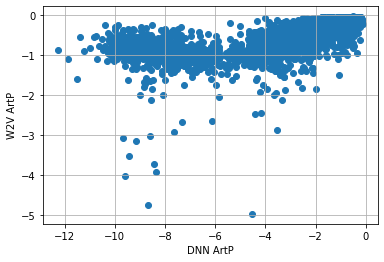

In [41]:
plt.scatter(w2v_df['vikram_artp'], w2v_df['w2v_artp'])
plt.grid()
plt.xlabel('DNN ArtP')
plt.ylabel('W2V ArtP')

In [49]:
plt.scatter(joined_df['artp'], joined_df['vikram_artp_y'])

/home/prad/anaconda3/envs/alignment/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [110]:
joined_df = gmmals_df.merge(dnnals_df, how='inner', on='File_id')
joined_df = joined_df.merge(w2v_df, how='inner', on='File_id')

Text(0, 0.5, 'Num Files')

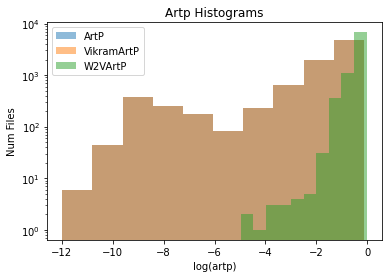

In [80]:
plt.title('Artp Histograms')
plt.hist(gmmals_df[phones].mean(axis=1), log=True, alpha=.5, label='ArtP')
plt.hist(w2v_df[phones].mean(axis=1), log=True, alpha=.5, label='VikramArtP')
plt.hist(w2v_df['w2v_artp'], log=True, alpha=.5, label='W2VArtP')
plt.legend()
plt.xlabel('log(artp)')
plt.ylabel('Num Files')